In [2]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

e:\STT_Assignment_3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data = pd.read_csv('commits_with_radon_metrics.csv', escapechar='\\')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

model.eval()
model.to('cuda')

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [6]:
def generate_embedding_codebert(message):
    message = str(message).strip()
    marked_text = "<s>" + message + "</s>"

    tokenized_text = tokenizer.tokenize(marked_text, truncation=True, max_length=tokenizer.model_max_length)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens]).to('cuda')

    with torch.no_grad():
        outputs = model(tokens_tensor)
        last_hidden_states = outputs[0]
        sentence_embedding = last_hidden_states[0, 0, :]

    result = sentence_embedding.cpu().numpy()

    del tokens_tensor, outputs, last_hidden_states, sentence_embedding
    torch.cuda.empty_cache()

    return result

In [8]:
before_bert_embeddings = np.array([generate_embedding_codebert(msg) for msg in data["Source code(before)"].tolist()])
after_bert_embeddings = np.array([generate_embedding_codebert(msg) for msg in data["Source code(after)"].tolist()])

<Axes: title={'center': 'Distribution of semantic similarity scores'}, xlabel='index', ylabel='Semantic similarity using CodeBERT'>

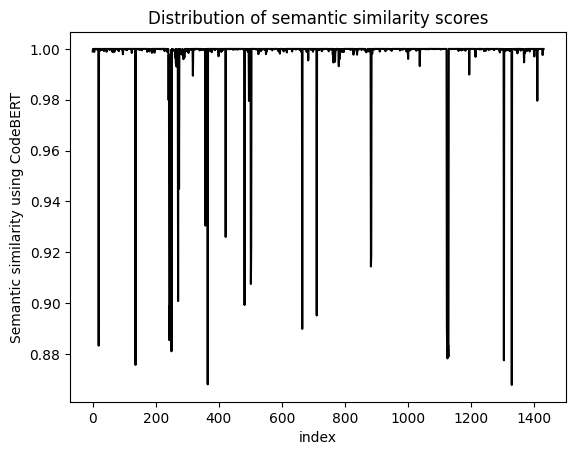

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
def rowwise_cosine_similarity(a, b):
    sims = []
    for i in range(len(a)):
        sims.append(cosine_similarity(a[i].reshape(1, -1), b[i].reshape(1, -1))[0, 0])
    return sims

data["Semantic Similarity"] = rowwise_cosine_similarity(before_bert_embeddings, after_bert_embeddings)
data["Semantic Similarity"].plot(xlabel='index', ylabel='Semantic similarity using CodeBERT', title='Distribution of semantic similarity scores', color='black')


<Axes: title={'center': 'Distribution of token similarity scores'}, xlabel='index', ylabel='Token Similarity using SacreBLEU'>

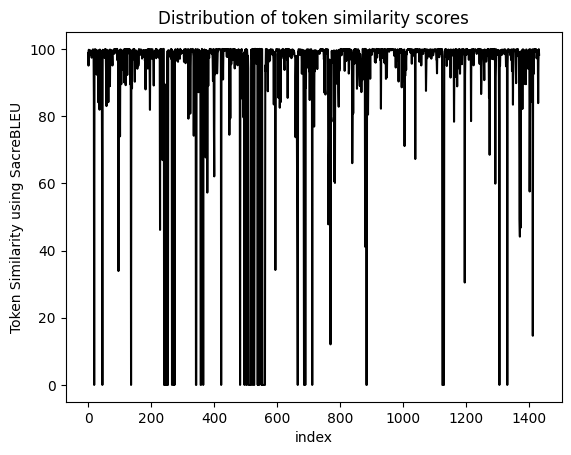

In [ ]:
import sacrebleu

def generate_score_bleu(a, b):
    if type(a) != str: a = "" #in someplaces a is nan (possibly becasuse that file didnt exist before and was added in the commit)
    if type(b) != str: b = ""
    return sacrebleu.corpus_bleu([a], [[b]]).score

bleu_score = []
for x, y in zip(data['Source code(before)'], data['Source code(after)']):
    bleu_score.append(generate_score_bleu(x, y))

data['Token similarity'] = bleu_score
data['Token similarity'].plot(xlabel='index', ylabel='Token Similarity using SacreBLEU', title='Distribution of token similarity scores', color='black')

In [55]:
print('Mean token similarity', data['Token similarity'].mean())
print('Median token similarity', data['Token similarity'].median())

Mean token similarity 92.4327350922892
Median token similarity 99.17323722671192


In [56]:
data.to_csv('commits_with_similarity_metrics.csv', index=False, escapechar='\\')

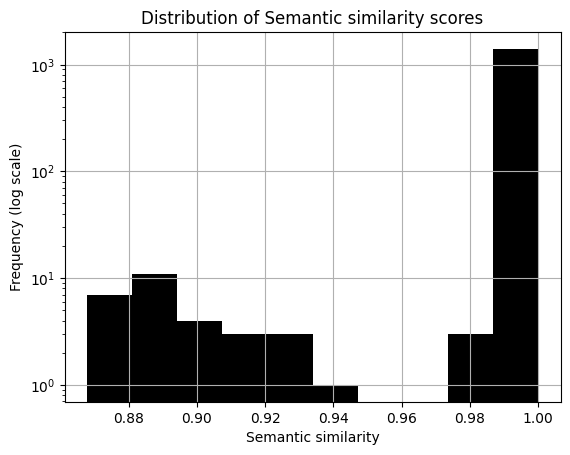

In [10]:
import matplotlib.pyplot as plt

data = pd.read_csv('commits_with_similarity_metrics.csv', escapechar='\\')
plt.figure()
data['Semantic Similarity'].hist(log=True, color='black')
plt.xlabel('Semantic similarity')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Semantic similarity scores')
plt.show()

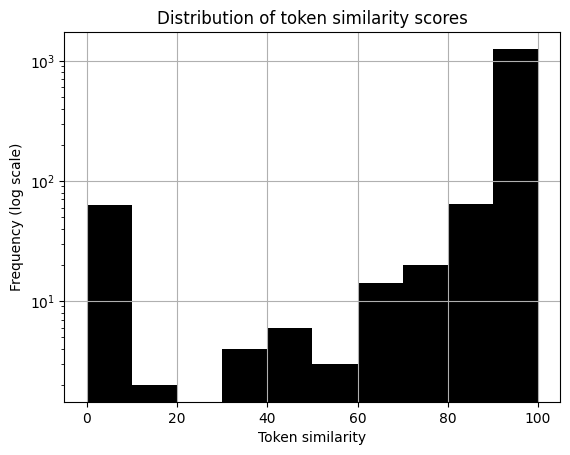

In [9]:
import matplotlib.pyplot as plt

data = pd.read_csv('commits_with_similarity_metrics.csv', escapechar='\\')
plt.figure()
data['Token similarity'].hist(log=True, color='black')
plt.xlabel('Token similarity')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of token similarity scores')
plt.show()

Lets choose the threshold for a Major commit to be 0.96 for semantic similarity and 0.8 for token similarity.

In [ ]:
data = pd.read_csv('commits_with_similarity_metrics.csv', escapechar='\\')

data['Semantic Class'] = np.where(data["Semantic Similarity"] > 0.96, "Minor", "Major")
data['Token Class'] = np.where(data["Token similarity"] > 0.8, "Minor", "Major")

In [12]:
print(data['Token Class'].value_counts())
print(data['Semantic Class'].value_counts())

Token Class
Minor    1369
Major      63
Name: count, dtype: int64
Semantic Class
Minor    1403
Major      29
Name: count, dtype: int64


In [13]:
data['Class Agree'] = data['Semantic Class'] == data['Token Class']
data['Class Agree'].value_counts()

Class Agree
True     1398
False      34
Name: count, dtype: int64

In [28]:
data.to_csv('final.csv', index=False, escapechar='\\')

In [3]:
need = pd.read_csv("commits_with_similarity_metrics.csv", escapechar='\\')
need.sample(5)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Hash,Message,Filename,Source code(before),Source code(after),Diff,LLM Inference,rectified message,MI_Change,CC_Change,LOC_Change,Semantic Similarity,Token similarity
666,666,666,666,34851761e294cbb9150f4575b1604e791e5f8c8a,Many more ode1 scenes and fixes as the video g...,stage_scenes.py,#!/usr/bin/env python\nimport inspect\nimport ...,#!/usr/bin/env python\nimport inspect\nimport ...,"@@ -43,7 +43,7 @@ def stage_scenes(module_name...",update example script,"""Update example script for ode1 scenes and fix...",0.000000,0,0,1.000000,99.200847
1049,1049,1049,1049,a3e4246938ece17ed8c0183a573b12ea1f890dfd,use log.debug and display idx+1,space_ops.py,from __future__ import annotations\n\nimport m...,from __future__ import annotations\n\nimport m...,"@@ -417,7 +417,7 @@ def earclip_triangulation(...",fix earclip triangulation,Use log.debug and display idx+1\nLLM: Fix earc...,-0.018947,0,0,1.000000,99.841514
291,291,291,291,0978984541bf99c4a1ff3ac8664c9f3580a19ccb,Reorganized animations folder. Warning: While...,vector_space_scene.py,import numpy as np\n\nfrom scene.scene import ...,import numpy as np\n\nfrom animation.animation...,"@@ -1,20 +1,35 @@\n import numpy as np\n \n-fr...",add missing imports,import numpy as np\nfrom mobject.vectorized_mo...,-0.590716,0,15,0.996581,97.078713
393,393,393,393,f4022d6c750d6cb54dc9f9612695ed9f99939a70,Fixed small bug with FadeInAndShiftFromDirection,creation.py,from __future__ import absolute_import\n\nimpo...,from __future__ import absolute_import\n\nimpo...,"@@ -151,7 +151,8 @@ class FadeInAndShiftFromDi...",add tests for fadein and fadeout,Fixed small bug with FadeInAndShiftFromDirecti...,-0.221737,0,2,1.000000,99.137367
287,287,287,287,0978984541bf99c4a1ff3ac8664c9f3580a19ccb,Reorganized animations folder. Warning: While...,numerals.py,\nfrom mobject.vectorized_mobject import VMobj...,\nfrom animation.animation import Animation\nf...,"@@ -1,11 +1,13 @@\n \n-from mobject.vectorized...",add missing imports,"""Reorganized animations folder with added impo...",-0.307944,0,2,0.999709,98.108665


In [63]:
final = pd.read_csv('final.csv', escapechar='\\')
display(final.sample(3))
display(final[final['Semantic Class'] == 'Major'].sample(2))

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Hash,Message,Filename,Source code(before),Source code(after),Diff,LLM Inference,rectified message,MI_Change,CC_Change,LOC_Change,Semantic Similarity,Token similarity,Semantic Class,Token Class,Class Agree
766,766,766,766,23bbdc63bac7a295498f08d7d035ead78b2f77fb,Fix up fill shaders to work when being viewed ...,vectorized_mobject.py,import itertools as it\nimport moderngl\n\nfro...,import itertools as it\nimport moderngl\n\nfro...,"@@ -19,10 +19,12 @@ from manimlib.utils.iterab...",add more info about triangulation and triangul...,Fix up fill shaders to work when being viewed ...,0.651555,-2,7,0.999723,96.828092,Minor,Minor,True
671,671,671,671,86a8cefc0f2122767155d632cce8288617dd2930,Fixed ClockPassesTime animation,drawings.py,import itertools as it\n\nfrom manimlib.animat...,import itertools as it\n\nfrom manimlib.animat...,"@@ -393,11 +393,13 @@ class ClockPassesTime(An...",add a missing rotation to clockpassestime,Fixed ClockPassesTime animation with added rot...,-0.040189,0,2,1.000000,99.783143,Minor,Minor,True
533,533,533,533,afdf907abc07eb7a7d2dc2331cc2e75046198eb1,"fix imports, remove __init__.py files, some pe...",common_scenes.py,import random\nimport string\n\nfrom manimlib....,import random\n\nfrom manimlib.animation.compo...,"@@ -1,7 +1,5 @@\n import random\n-import strin...",add missing import,"""Fix imports, remove __init__.py files, and ad...",0.125230,0,-2,0.999723,99.530152,Minor,Minor,True


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Hash,Message,Filename,Source code(before),Source code(after),Diff,LLM Inference,rectified message,MI_Change,CC_Change,LOC_Change,Semantic Similarity,Token similarity,Semantic Class,Token Class,Class Agree
665,665,665,665,34851761e294cbb9150f4575b1604e791e5f8c8a,Many more ode1 scenes and fixes as the video g...,solve_pendulum_ode_sample_code.py,NaN,import numpy as np\n\n# Physical constants\ng ...,"@@ -0,0 +1,63 @@\n+import numpy as np\n+\n+# P...",add formula for theta and thetadot,"""Add formula for theta and thetadot in ode1 sc...",87.038245,3,63,0.889864,0.0,Major,Major,True
1305,1305,1305,1305,1fa17030a2d668fd2a6ad0fc1b3901ff447c7cb1,Add `reload()` command for interactive scene r...,reload_manager.py,NaN,from typing import Any\nfrom IPython.terminal....,"@@ -0,0 +1,84 @@\n+from typing import Any\n+fr...",add reload manager,Add reload manager,79.471557,20,84,0.877498,0.0,Major,Major,True
